In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob

from datetime import datetime
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

In [186]:
# 读取所有 CSV 文件
file_list = glob.glob('../../data/Window_Ads/*.csv')

for i in range(len(file_list)):
    url = file_list[i]
    
    # 提取文件名（去掉路径）
    file_name = Path(file_list[i]).stem  # 获取 '2025.01.22'

    # 替换文件名中的 '.' 为 '-' (防止干扰日期解析)
    formatted_date = file_name.replace('.', '-')

    try:
        # 将格式化后的日期字符串转换为日期对象
        day = pd.to_datetime(formatted_date, format='%Y-%m-%d').day_name()
    except ValueError:
        day = 'Invalid Date'  # 如果解析失败，标记为无效日期

    # 存储到字典格式
    file_list[i] = {day: url}

print(file_list)

[{'Wednesday': '../../data/Window_Ads/2025.01.22.csv'}, {'Thursday': '../../data/Window_Ads/2025.01.23.csv'}, {'Friday': '../../data/Window_Ads/2025.01.24.csv'}, {'Saturday': '../../data/Window_Ads/2025.01.25.csv'}, {'Sunday': '../../data/Window_Ads/2025.01.26.csv'}]


# Workdays

In [187]:
# 按小时顺序排序（手动定义时间段顺序）
hour_order = [
    '12 am – 1 am', '1 am – 2 am', '2 am – 3 am', '3 am – 4 am',
    '4 am – 5 am', '5 am – 6 am', '6 am – 7 am', '7 am – 8 am',
    '8 am – 9 am', '9 am – 10 am', '10 am – 11 am', '11 am – 12 pm',
    '12 pm – 1 pm', '1 pm – 2 pm', '2 pm – 3 pm', '3 pm – 4 pm',
    '4 pm – 5 pm', '5 pm – 6 pm', '6 pm – 7 pm', '7 pm – 8 pm',
    '8 pm – 9 pm', '9 pm – 10 pm', '10 pm – 11 pm', '11 pm – 12 am'
]

Workdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

Workdays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Workdays]
Workdays = pd.concat(Workdays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Workdays['Impressions'] = pd.to_numeric(Workdays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Workdays['Avg. CPC'] = Workdays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Workdays['Cost'] = Workdays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 确保小时的格式完整，不进行 24 小时转换
Workdays_grouped = Workdays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean'
}).reset_index()

Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 显示最终结果
print(Workdays_grouped)

             Hour     Clicks  Impressions  Avg. CPC      Cost
6    12 am – 1 am   2.666667    25.000000  0.106667  0.516667
0     1 am – 2 am   5.000000    21.333333  0.183333  0.816667
8     2 am – 3 am   3.000000    19.000000  0.236667  0.710000
10    3 am – 4 am   1.333333    25.333333  0.110000  0.240000
12    4 am – 5 am   2.666667    28.333333  0.336667  0.800000
14    5 am – 6 am   2.000000    21.333333  0.160000  0.443333
16    6 am – 7 am   2.000000    14.666667  0.113333  0.346667
18    7 am – 8 am   1.000000     9.333333  0.080000  0.126667
20    8 am – 9 am   0.666667     5.333333  0.133333  0.133333
22   9 am – 10 am   1.000000    11.666667  0.140000  0.206667
2   10 am – 11 am   1.666667    13.000000  0.063333  0.320000
4   11 am – 12 pm   1.000000     8.000000  0.183333  0.183333
7    12 pm – 1 pm   0.666667     9.333333  0.140000  0.140000
1     1 pm – 2 pm   1.333333     7.666667  0.066667  0.263333
9     2 pm – 3 pm   1.333333     8.000000  0.136667  0.293333
11    3 

In [188]:
workdays_X = Workdays_grouped.drop(columns=['Hour']).reset_index(drop=True)
workdays_Y = Workdays_grouped['Hour'].reset_index(drop=True)

train_workdays_X, test_workdays_X, train_workdays_Y, test_workdays_Y = train_test_split(
    workdays_X, workdays_Y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))
train_workdays_X = scaler.fit_transform(train_workdays_X)
train_workdays_X

array([[0.03296703, 0.09943182, 0.41584158, 0.02809243],
       [0.04395604, 0.06534091, 0.1980198 , 0.0357952 ],
       [0.16483516, 0.18181818, 0.54455446, 0.11101042],
       [1.        , 0.27556818, 0.40594059, 1.        ],
       [0.06593407, 0.18181818, 0.47524752, 0.0602628 ],
       [0.0989011 , 0.16193182, 0.7029703 , 0.0965111 ],
       [0.02197802, 0.07954545, 0.41584158, 0.01903036],
       [0.06593407, 0.13352273, 0.30693069, 0.04666969],
       [0.04395604, 0.21590909, 0.32673267, 0.03262347],
       [0.08791209, 0.24147727, 1.        , 0.1087449 ],
       [0.07692308, 0.20738636, 0.2970297 , 0.09379248],
       [0.27472527, 1.        , 0.27722772, 0.31173539],
       [0.05494505, 0.10795455, 0.32673267, 0.03851382],
       [0.        , 0.        , 0.        , 0.        ],
       [0.03296703, 0.07954545, 0.23762376, 0.01721794],
       [0.05494505, 0.11079545, 0.18811881, 0.04349796],
       [0.04395604, 0.06818182, 0.40594059, 0.03987313],
       [0.68131868, 0.05397727,

最佳 K 值: 2, 轮廓系数: 0.713


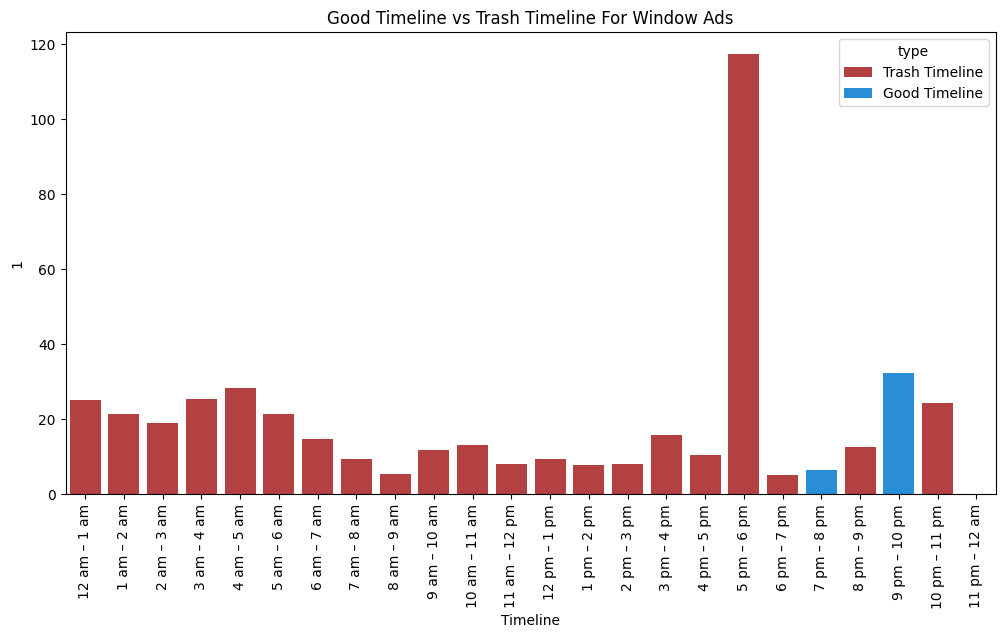

In [189]:
# 定义 K 值的搜索范围
param_grid = {'n_clusters': range(2, 10)}

best_k = None
best_score = -1

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_workdays_X)
    score = silhouette_score(train_workdays_X, labels)
    
    if score > best_score:
        best_score = score
        best_k = params['n_clusters']

print(f"最佳 K 值: {best_k}, 轮廓系数: {best_score:.3f}")

# 使用最佳 K 值进行最终聚类（使用完整数据）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# 在完整数据集上进行聚类预测
Workdays_grouped['Cluster'] = kmeans.fit_predict(scaler.transform(workdays_X))

# 映射聚类标签，0 代表垃圾时间段，1 代表优质时间段（示例，实际需检查）
Workdays_grouped['Cluster_Label'] = Workdays_grouped['Cluster'].map({0: 'Trash Timeline', 1: 'Good Timeline'})

# 按小时顺序排序
Workdays_grouped['Hour'] = pd.Categorical(Workdays_grouped['Hour'], categories=hour_order, ordered=True)
Workdays_grouped = Workdays_grouped.sort_values('Hour')

# 创建用于可视化的 DataFrame，设置所有值为1，便于条形图展示
Workdays_grouped['Value'] = Workdays_grouped['Impressions']

# 定义颜色映射，优质时间段为绿色，垃圾时间段为红色
color_map = {
    'Trash Timeline': '#C62E2E',
    'Good Timeline': '#0D92F4',
    
}

# 绘制条形统计图
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Hour', 
    y='Value', 
    hue='Cluster_Label', 
    data=Workdays_grouped, 
    palette=color_map,
    dodge=False  # 避免多分类偏移
)

# 美化图表
plt.xticks(rotation=90)
plt.title('Good Timeline vs Trash Timeline For Window Ads')
plt.xlabel('Timeline')
plt.ylabel('1')
plt.legend(title='type')
plt.show()

# Holidays

In [190]:
Holidays = ['Saturday', 'Sunday']

Holidays_list = [pd.read_csv(list(item.values())[0]) for item in file_list if list(item.keys())[0] in Holidays]
Holidays = pd.concat(Holidays_list, ignore_index=True)

# 处理 Impressions 列，转换为整数
Holidays['Impressions'] = pd.to_numeric(Holidays['Impressions'], errors='coerce').fillna(0).astype(int)

# 去掉"$"符号并转换为 float
Holidays['Avg. CPC'] = Holidays['Avg. CPC'].replace(r'[\$,]', '', regex=True).astype(float)
Holidays['Cost'] = Holidays['Cost'].replace(r'[\$,]', '', regex=True).astype(float)

# 确保小时的格式完整，不进行 24 小时转换
Holidays_grouped = Holidays.groupby('Hour').agg({
    'Clicks': 'mean',
    'Impressions': 'mean',
    'Avg. CPC': 'mean',
    'Cost': 'mean'
}).reset_index()

Holidays_grouped['Hour'] = pd.Categorical(Holidays_grouped['Hour'], categories=hour_order, ordered=True)
Holidays_grouped = Holidays_grouped.sort_values('Hour')

# 显示最终结果
print(Holidays_grouped)

             Hour  Clicks  Impressions  Avg. CPC   Cost
6    12 am – 1 am    31.5         64.0     0.230  8.860
0     1 am – 2 am    27.5        265.0     0.235  6.570
8     2 am – 3 am     7.0         64.5     0.110  1.550
10    3 am – 4 am    20.0        312.5     0.175  5.420
12    4 am – 5 am    24.5        252.0     0.150  7.365
14    5 am – 6 am     0.5          2.0     0.085  0.085
16    6 am – 7 am     0.0          3.0     0.000  0.000
18    7 am – 8 am     0.0          2.5     0.000  0.000
20    8 am – 9 am     0.0          1.0     0.000  0.000
22   9 am – 10 am     1.0          5.5     0.090  0.185
2   10 am – 11 am     0.0          1.5     0.000  0.000
4   11 am – 12 pm     0.0          0.0     0.000  0.000
7    12 pm – 1 pm     0.0          0.0     0.000  0.000
1     1 pm – 2 pm     0.5          2.5     0.060  0.060
9     2 pm – 3 pm     0.0          2.0     0.000  0.000
11    3 pm – 4 pm     0.5          3.5     0.040  0.040
13    4 pm – 5 pm     2.5         18.0     0.075

In [191]:
Holidays_X = Holidays_grouped.drop(columns=['Hour']).reset_index(drop=True)
Holidays_Y = Holidays_grouped['Hour'].reset_index(drop=True)

train_holidays_X, test_holidays_X, train_holidays_Y, test_holidays_Y = train_test_split(
    Holidays_X, Holidays_Y, test_size=0.2, random_state=42
)

scaler = MinMaxScaler(feature_range=(0, 1))
train_holidays_X = scaler.fit_transform(train_holidays_X)
train_holidays_X

array([[0.03636364, 0.0176    , 0.38297872, 0.02511881],
       [0.01818182, 0.008     , 0.25531915, 0.00814664],
       [1.        , 0.848     , 1.        , 0.89205703],
       [0.        , 0.        , 0.        , 0.        ],
       [0.01818182, 0.0064    , 0.36170213, 0.01154107],
       [0.25454545, 0.2064    , 0.46808511, 0.21045485],
       [0.        , 0.        , 0.        , 0.        ],
       [0.01818182, 0.0112    , 0.17021277, 0.00543109],
       [0.72727273, 1.        , 0.74468085, 0.7359131 ],
       [0.89090909, 0.8064    , 0.63829787, 1.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.01818182, 0.088     , 0.38297872, 0.01221996],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.008     , 0.        , 0.        ],
       [0.        , 0.0048    , 0.        , 0.        ],
       [0.        , 0.0064    , 0.        , 0.        ],
       [0.09090909, 0.08      ,

最佳 K 值: 2, 轮廓系数: 0.835


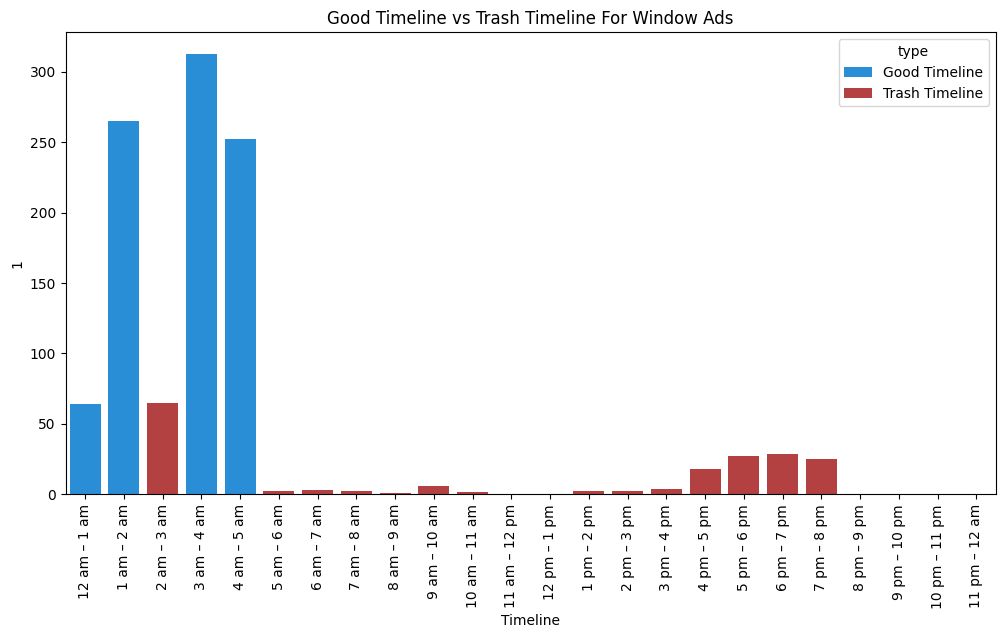

In [192]:
# 定义 K 值的搜索范围
param_grid = {'n_clusters': range(2, 10)}

best_k = None
best_score = -1

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=params['n_clusters'], random_state=42, n_init=10)
    labels = kmeans.fit_predict(train_holidays_X)
    score = silhouette_score(train_holidays_X, labels)
    
    if score > best_score:
        best_score = score
        best_k = params['n_clusters']

print(f"最佳 K 值: {best_k}, 轮廓系数: {best_score:.3f}")

# 使用最佳 K 值进行最终聚类（使用完整数据）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)

# 在完整数据集上进行聚类预测
Holidays_grouped['Cluster'] = kmeans.fit_predict(scaler.transform(Holidays_X))

# 映射聚类标签，0 代表垃圾时间段，1 代表优质时间段（示例，实际需检查）
Holidays_grouped['Cluster_Label'] = Holidays_grouped['Cluster'].map({0: 'Trash Timeline', 1: 'Good Timeline'})

# 按小时顺序排序
Holidays_grouped['Hour'] = pd.Categorical(Holidays_grouped['Hour'], categories=hour_order, ordered=True)
Holidays_grouped = Holidays_grouped.sort_values('Hour')

# 创建用于可视化的 DataFrame，设置所有值为1，便于条形图展示
Holidays_grouped['Value'] = Holidays_grouped['Impressions']

# 定义颜色映射，优质时间段为绿色，垃圾时间段为红色
color_map = {
    'Good Timeline': '#0D92F4',
    'Trash Timeline': '#C62E2E'
}

# 绘制条形统计图
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Hour', 
    y='Value', 
    hue='Cluster_Label', 
    data=Holidays_grouped, 
    palette=color_map,
    dodge=False  # 避免多分类偏移
)

# 美化图表
plt.xticks(rotation=90)
plt.title('Good Timeline vs Trash Timeline For Window Ads')
plt.xlabel('Timeline')
plt.ylabel('1')
plt.legend(title='type')
plt.show()